In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import re

import lxml.html
import numpy as np
from sketchtml.repeats import TagPathClustering

In [133]:
import requests

#page = requests.get('https://pycon.jp/2014/schedule/talks/list/')
#page_content = page.text
page_content = open('samples/PyCon Korea 2018.html').read()

In [134]:
from collections import Counter

clustering = TagPathClustering(page_content,
                               with_id=False,
                               with_classes=True,
                               strip_digits=False)
clustering._build_tagpaths()

for tp, cnt in Counter(clustering.tagpaths).most_common():
    if cnt > 1:
        print('({:3d}) {}'.format(cnt, tp))

(218) /html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small
(208) /html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small
(196) /html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td
(134) /html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small/a
(129) /html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/a
(102) /html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td
( 98) /html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr
( 98) /html/body/main/div.container/div.content/div.timetable.tim

In [135]:
clusters = clustering.clusters()
#clusters

In [136]:
#clustering.simhelper.plot_signals()

In [137]:
from pprint import pprint as pp

pp(clusters)

defaultdict(<class 'list'>,
            {0: ['/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/a',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small/a'],
             1: ['/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/h2',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.ta

In [138]:
from functools import partial
from typing import Tuple
from pprint import pformat

_node_repr = partial(TagPathClustering.node_repr,
                             with_classes=True,
                             with_id=False,
                             with_attr_names=False,
                             strip_digits=False)
class TrieNode(object):
    """
    Our trie node implementation. Very basic. but does the job
    """
    
    def __init__(self, char_repr):
        self.char_repr = char_repr
        self.elements = set()
        self.children = []
        # Is it the last character of the word.`
        self.word_finished = False
        # How many times this character appeared in the addition process
        self.counter = 1
    
    def __repr__(self):
        return pformat(dict(char_repr=self.char_repr, elements=len(set(self.elements)), children=self.children))

def add(root, word):
    """
    Adding a word in the trie structure
    """
    node = root
    #print('Root: {}, Word: {}'.format(root, word))
    for char in word:
        char_repr = _node_repr(char)
        #print('Char: {}'.format(char_repr))
        found_in_child = False
        # Search for the character in the children of the present `node`
        for child in node.children:
            if child.char_repr == char_repr:
                # We found it, increase the counter by 1 to keep track that another
                # word has it as well
                child.counter += 1
                # And point the node to the child that contains this char
                node = child
                found_in_child = True
                #print('Child found.')
                node.elements.add(char)
                break
        # We did not find it so add a new chlid
        if not found_in_child:
            new_node = TrieNode(char_repr)
            new_node.elements.add(char)
            node.children.append(new_node)
            # And then point node to the new child
            node = new_node
            #print('Child NOT found. Creating new TrieNode({})'.format(char))
    # Everything finished. Mark it as the end of a word.
    node.word_finished = True

In [139]:
from pprint import pprint

for n, cluster in sorted(clusters.items()):
    if len(cluster) < 3:
        continue

    print('---- Cluster #{} ----'.format(n))
    for tp in sorted(cluster, key=lambda tp: tp.split('/')):
        to_print = []
        try:
            for nodepath in clustering.tagpath_nodes[tp][:10]:
                node = nodepath[-1]
                e = node.element
                texts = [s.strip() for s in e.xpath('./text()[normalize-space()]')]
                attribs = {k: v for k, v in e.attrib.items() if k not in ['class']}
                t = ' '.join(texts)
                #if t or attribs:
                if t:
                    to_print.append((node.doc_order, t, attribs))
            if to_print:
                print('---\n'+tp)
                for e in to_print:
                    print(e)
                print()
        except Exception as e:
            print(str(e))
            pass

---- Cluster #0 ----
---
/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/a
(136, 'Opening', {'href': '/2018/en/program/54'})
(145, "'그리고 물고기는 고마웠어요'", {'href': '/2018/en/program/55'})
(158, 'Break', {'href': '/2018/en/program/56'})
(163, 'Why I Learn. How I Learn', {'href': '/2018/en/program/57'})
(176, 'Break', {'href': '/2018/en/program/58'})
(181, 'Committing to diversity and inclusion', {'href': '/2018/en/program/59'})
(191, 'Lunch', {'href': '/2018/en/program/60'})
(196, 'I can do it! Open source: from setup.py to PyPI', {'href': '/2018/en/program/38'})
(208, 'Investigating life: Making news that improve our daily life', {'href': '/2018/en/program/35'})
(220, 'Implementing Microservice using Sanic', {'href': '/2018/en/program/37'})

---- Cluster #1 ----
---
/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/h2
(1152, '2018-08-18 (Sat)', {})
(1821, '2018-08-19 (Sun)', {})

---
/html/body/main/

In [176]:
root = TrieNode('')
nodelists = clustering.tagpath_nodes
tps = [

                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/a',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small',
                 '/html/body/main/div.container/div.content/div.timetable.timetable-narrow.visible-xs/table.table/tbody/tr/td/small/a',

                 #'/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/a.title',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/a.title/div',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/a.title/div/span.glyphicon.glyphicon-eye-close',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/a',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/a/span.label.label-slides',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/a/span.label.label-video',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/span.label.label-difficulty-b',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/span.label.label-difficulty-e',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/span.label.label-difficulty-i',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.program/small/span.label.label-english-session',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.speaker',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.speaker/a',
                 '/html/body/main/div.container/div.content/div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr/td.cell/div.speaker/a/img',
]
for i in [2, 3, 7]:
  for tp in clusters[i]:
#for tp in tps:
    steps = tp.lstrip('/').split('/')
    #print(len(steps), tp)
    for nl in nodelists[tp][:]:
        #print(len(nl), [(n.element.tag, n.doc_order) for n in nl])
        add(root, nl)
    #print()

In [177]:
#root

In [178]:
def collapse(trienode):
    for c in trienode.children:
        collapse(c)
    if len(trienode.children) == 1 and not trienode.word_finished:
        trienode.char_repr += '/'+trienode.children[0].char_repr
        trienode.elements = trienode.children[0].elements
        
        trienode.children = trienode.children[0].children
        

In [179]:
collapse(root)
root

{'char_repr': '/html',
 'children': [{'char_repr': 'body',
 'children': [{'char_repr': 'footer.text-center/div.container/p',
 'children': [],
 'elements': 2},
              {'char_repr': 'main/div.container',
 'children': [{'char_repr': 'div.content',
 'children': [{'char_repr': 'div.hidden-xs.timetable.timetable-wide/table.table.table-bordered.table-striped/tbody/tr',
 'children': [{'char_repr': 'td', 'children': [], 'elements': 102},
              {'char_repr': 'td.cell',
 'children': [{'char_repr': 'div.program',
 'children': [{'char_repr': 'a.title',
 'children': [{'char_repr': 'div',
 'children': [{'char_repr': 'span.glyphicon.glyphicon-eye-close',
 'children': [],
 'elements': 2}],
 'elements': 80}],
 'elements': 80},
              {'char_repr': 'small',
 'children': [{'char_repr': 'a',
 'children': [{'char_repr': 'span.label.label-slides', 'children': [], 'elements': 60},
              {'char_repr': 'span.label.label-video', 'children': [], 'elements': 69}],
 'elements': 129},
 

In [180]:
def hydrate_trie(node):
    return dict(
        tag=node.char_repr if node.char_repr else node.char_repr,
        element=set(node.elements),
        children=[hydrate_trie(c) for c in node.children],
        word_finished=node.word_finished
    )
hydrate_trie(root)

{'tag': '/html',
 'element': {Node(tag='html', doc_order=2, child_position=1, attribs={'lang': 'en'}, element=<Element html at 0x7fc528c26048>)},
 'children': [{'tag': 'body',
   'element': {Node(tag='body', doc_order=26, child_position=1, attribs={}, element=<Element body at 0x7fc529565fc8>)},
   'children': [{'tag': 'footer.text-center/div.container/p',
     'element': {Node(tag='p', doc_order=2720, child_position=1, attribs={}, element=<Element p at 0x7fc52890ac88>),
      Node(tag='p', doc_order=2721, child_position=2, attribs={}, element=<Element p at 0x7fc52890ab48>)},
     'children': [],
     'word_finished': False},
    {'tag': 'main/div.container',
     'element': {Node(tag='div', doc_order=125, child_position=1, attribs={'class': 'container'}, element=<Element div at 0x7fc529034288>),
      Node(tag='div', doc_order=2609, child_position=2, attribs={'class': 'container'}, element=<Element div at 0x7fc52893a788>)},
     'children': [{'tag': 'div.content',
       'element': {No

In [184]:
from collections import defaultdict
from operator import itemgetter

def hydrate_trie2(node, docorder_min, docorder_max=None):
    elements = sorted(set(node.elements), key=lambda n: n.doc_order)
    output = []
    for i, element in enumerate(elements, start=1):
        if not (docorder_min < element.doc_order):
            continue
        if docorder_max is not None and (element.doc_order > docorder_max):
            continue
        e = {'tag': _node_repr(element),
             'doc_order': element.doc_order}
        _t = [t.strip() for t in element.element.xpath('./text()[normalize-space()]')]
        if _t:
        #if True:
            e['text'] = _t[0] if len(_t) == 1 else _t
        if element.element.attrib:
            e['attrib'] = element.element.attrib
        _order_min = element.doc_order
        if i < len(elements):
            _order_max = elements[i].doc_order
        else:
            _order_max = None
        #print((element, _order_min, _order_max))
        children = list(filter(bool, [c for child in node.children
                                      for c in hydrate_trie2(child, _order_min, _order_max)]))
        if children:
            e['children'] = sorted(children, key=itemgetter('doc_order'))
            
        if 'children' not in e and 'text' not in e:
            continue
        #if len(children) == 1:
            #e = children[0]
            #e['tag'] = '{}/{}'.format(_node_repr(element), e['tag'])
        output.append(e)
    #if len(output) == 1:
    #    return output[0]
    return sorted(output, key=itemgetter('doc_order'))
pp(hydrate_trie2(root.children[0], 0))

[{'children': [{'attrib': {'class': 'collapse navbar-collapse', 'id': 'navbar-collapse-1'},
                'children': [{'attrib': {'class': ''},
                              'children': [{'attrib': {'href': '/2018/en/about/pyconkr'},
                                            'doc_order': 42,
                                            'tag': 'a',
                                            'text': 'About PyCon Korea 2018'}],
                              'doc_order': 41,
                              'tag': 'li'},
                             {'attrib': {'class': ''},
                              'children': [{'attrib': {'href': '/2018/en/about/coc'},
                                            'doc_order': 44,
                                            'tag': 'a',
                                            'text': 'Code of Conduct'}],
                              'doc_order': 43,
                              'tag': 'li'},
                             {'attrib': {'class': ''}

In [183]:
simhelper = clustering.simhelper

In [47]:
from itertools import zip_longest, combinations
from collections import Counter


tagpaths = [
    tp for tp, cnt in Counter(clustering.tagpaths).most_common()
    if cnt > 1
]

l = len(tagpaths)
matrix = np.zeros((l, l))

for a, b in combinations(tagpaths, 2):
    ia, ib = tagpaths.index(a), tagpaths.index(b)
    try:
        matrix[ia, ib] = 1 - simhelper.similarity(a, b, epsilon=10)
    except:
        matrix[ia, ib] = 1
    matrix[ib, ia] = matrix[ia, ib]
    matrix[ia, ia] = 0
    matrix[ib, ib] = 0

In [48]:
from sklearn.cluster import AgglomerativeClustering

clustering2 = AgglomerativeClustering(n_clusters=l, affinity='precomputed', linkage='average')

clustering2.fit_predict(matrix)

array([21, 25, 24, 22, 23, 14, 19, 15, 10, 26, 16,  7, 17, 12, 11, 18,  8,
       20, 13,  6,  3,  9,  4,  5,  1,  2,  0])

In [49]:
# Authors: Mathew Kallada
# License: BSD 3 clause
"""
=========================================
Plot Hierarachical Clustering Dendrogram 
=========================================

This example plots the corresponding dendrogram of a hierarchical clustering
using AgglomerativeClustering and the dendrogram method available in scipy.
"""

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

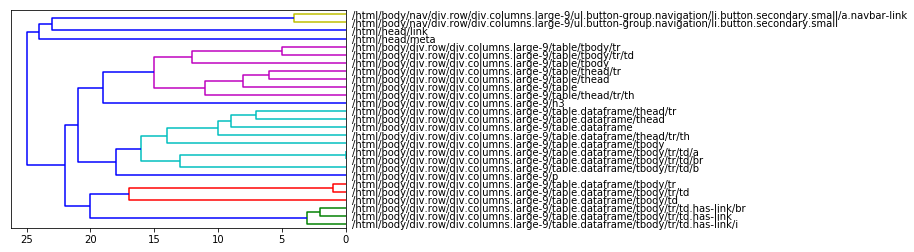

In [50]:
ax = plt.plot()
plot_dendrogram(clustering2, labels=tagpaths, orientation='left'
                #, leaf_font_size=8
               )

In [ ]:
root = TrieNode()

In [51]:
# borrowed from https://stackoverflow.com/questions/8484943/construct-a-tree-from-list-os-file-paths-python-performance-dependent
from collections import defaultdict

FILE_MARKER = '<files>'

def attach(branch, trunk):
    '''
    Insert a branch of directories on its trunk.
    '''
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
        return trunk
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []), ('<paths>', []), ('<texts>', [])))
        return attach(others, trunk[node])

def prettify(d, indent=0):
    '''
    Print the file tree structure with proper indentation.
    '''
    for key, value in d.items():
        if key == FILE_MARKER:
            if value:
                print('  ' * indent + str(value))
        elif key in ('<paths>', '<texts>'):
            if value:
                print('\n'.join('  ' * indent + v for v in value))
        else:
            print('  ' * indent + str(key))
            if isinstance(value, dict):
                prettify(value, indent+1)
            else:
                print('  ' * (indent+1) + str(value))

In [52]:
from pprint import pprint

for n, cluster in sorted(clusters.items()):
    if len(cluster) < 3:
        continue
    print('-------')
    print('Cluster #{}'.format(n))
    tree = defaultdict(dict, ((FILE_MARKER, []),))
    for tp in cluster:
        branch = attach(tp, tree)
        branch['<paths>'].append(tp)
        for nodepath in clustering.tagpath_nodes[tp][:10]:
            node = nodepath[-1]
            
            e = node.element
            texts = [s.strip() for s in e.xpath('./text()[normalize-space()]')]
            attribs = {k: v for k, v in e.attrib.items() if k not in ['class']}
            t = ' '.join(texts)
            if t.strip():
                branch['<texts>'].append(t)
    prettify(tree)

-------
Cluster #1

  html
    body
      div.row
        div.columns.large-9
          table.dataframe
            tbody
              tr
                td
                  ['br', 'a', 'b']
                  /html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td/br
                  /html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td/a
                  /html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td/b
                  How to drive business decisions with AI
                  Python in medicine: signal processing - learning and visualization of temporal data
                  Felix Wick
                  Annalisa Barla
-------
Cluster #2

  html
    head
      ['link', 'meta']
      /html/head/link
      /html/head/meta
    body
      div.row
        div.columns.large-9
          ['h3', 'p']
          /html/body/div.row/div.columns.large-9/h3
          /html/body/div.row/div.columns.large-9/p
          Program
          Tuesday, 28 Augu

In [57]:
from collections import defaultdict, Counter
from functools import partial
import hashlib

import pygtrie
from pprint import pprint as pp
from pprint import pformat as pf

from html2text import html2text
from lxml.html import tostring
from slugify import slugify
import html_text

tohtml = partial(tostring, encoding='unicode')
totxt = html_text.extract_text

def hydrate(tree, doc, parent_path, merge_keys=True):
    relative_path = '>'.join(
        tree['_path'][len(parent_path):]
    ).lstrip('>')
    data = []
    _key = None
    for e in doc.cssselect(relative_path):
        if _key is None:
            _key = slugify(' '.join(filter(bool, [e.tag] + [re.sub(r'[\-\d]+', '', a)
                                                            for a in e.attrib.get('class', '').split()])), to_lower=True, separator='_')
            _key = relative_path.split('>')[-1]
            h = hashlib.sha256()
            h.update(_key.encode('utf8'))
            _key = '{}_{}'.format(e.tag, h.hexdigest()[:4])
        record = {}
        children_groups = list(filter(bool, [
                hydrate(child, e, tree['_path'], merge_keys=merge_keys)
                for child in tree['_children']
            ]))
        if children_groups:
            if merge_keys:
                for group in children_groups:
                    children = defaultdict(list)
                    for child in group:
                        key = child.pop('_key')
                        _attr = child.get('_attribs')
                        if _attr:
                            _cls = _attr.get('class')
                            if _cls:
                                _attr.pop('class')
                                key = _cls
                            child.update(child.pop('_attribs'))
                        children[key].append(child)
                    record.update(children)
            else:
                record['_children'] = children_groups
        if tree['_value']:
            _t = ' '.join([re.sub(r'\s+', ' ', s)
                           for s in e.xpath('self::*[not(self::script) and not(self::style)]/text()[normalize-space()]')]).strip()
            #_t = totxt(tohtml(e))
            if _t:
                record['_text'] = _t
            #elif not record.get('_children'):
            elif not children_groups:
                #_t = '__NO-CHILDREN__'+e.xpath('normalize-space()').strip()
                _t = ' '.join([re.sub(r'\s+', ' ', s)
                    for s in e.xpath('self::*[not(self::script) and not(self::style)]/text()[normalize-space()]')]).strip()+_t
                #_t = totxt(tohtml(e))
                if _t:
                    if len(_t) > 50:
                        record['_text'] = _t[:50]+'...'
                    else:
                        record['_text'] = _t
            _a = {k: re.sub('\s+', ' ', v.strip())
                                      for k, v in e.attrib.items()
                                      if k not in  (
                                          #'class',
                                          'style',
                                      )}
            if _a:
                record['_attribs'] = _a
        if record:
            record['_key'] = _key
            data.append(record)
    #if data and len(data) == 1:
    #    return data[0]
    return data
    #return {d.pop('_key'): d for d in data}

def make(path_conv, path, children, value=None):
    children = list(children)
    if value is None and len(children) == 1:
        # There is only one prefix.
        return children[0]
    else:
        return {'_children': children,
                #'_value': value[:64]+'...'+value[-64:] if value else value,
                '_value': value,
                '_path': path}



In [54]:
for i, cluster in clusters.items():
    print('Cluster {}'.format(i))
    #print()
    c = Counter([len(tp.split('/')) for tp in cluster])
    #print(dict(c))
    print('Cluster size: {}, cluster depths: {} ({}), depth_diff={}'.format(len(cluster), c, len(c), (max(c) - min(c))))
    print()
    

Cluster 4
Cluster size: 3, cluster depths: Counter({9: 1, 8: 1, 7: 1}) (3), depth_diff=2

Cluster 5
Cluster size: 2, cluster depths: Counter({9: 1, 8: 1}) (2), depth_diff=1

Cluster 6
Cluster size: 3, cluster depths: Counter({10: 2, 9: 1}) (2), depth_diff=1

Cluster 7
Cluster size: 4, cluster depths: Counter({9: 1, 6: 1, 7: 1, 8: 1}) (4), depth_diff=3

Cluster 0
Cluster size: 2, cluster depths: Counter({8: 1, 9: 1}) (2), depth_diff=1

Cluster 3
Cluster size: 5, cluster depths: Counter({7: 2, 9: 1, 6: 1, 8: 1}) (4), depth_diff=3

Cluster 2
Cluster size: 5, cluster depths: Counter({4: 2, 6: 2, 8: 1}) (3), depth_diff=4

Cluster 1
Cluster size: 3, cluster depths: Counter({10: 3}) (1), depth_diff=0



In [ ]:
doc = lxml.html.fromstring(page_content)
for n, cluster in sorted(clusters.items()):
    size = len(cluster)
    #if size < 2 and size > 30:
    #    continue
    c = Counter([len(tp.split('/')) for tp in cluster])
    depth_diff = max(c) - min(c)
    #if depth_diff > 10:
    #    continue
    print("Cluster {}".format(n))
    tagpaths_trie = pygtrie.Trie()
    for tp in cluster:
        tagpaths_trie[tp.split('/')] = tp
        
    r = tagpaths_trie.traverse(make)
    
    o = hydrate(r, doc, '', merge_keys=False)
    print('Size {}'.format(len(o)))
    s = pf(o)
    print(s)

In [60]:
doc = lxml.html.fromstring(page_content)
tagpaths_trie = pygtrie.Trie()
for tp in clusters[6]:
    tagpaths_trie[tp.split('/')] = tp
additional_tps = [
    '/html/body/div.row/div.columns.large-9/h3',
]
for tp in additional_tps: 
    tagpaths_trie[tp.split('/')] = tp
    pass

r = tagpaths_trie.traverse(make)

o = hydrate(r, doc, '', merge_keys=True)
s = pf(o)

In [61]:
import json

JSON_FORMAT_KWARGS = {
    'indent': 2,
    'separators': (',', ': '),
    'sort_keys': True,
}
with open('test.euroscipy2018.json', 'w') as fp:
    json.dump(o, fp, **JSON_FORMAT_KWARGS)
    fp.write("\n")


In [73]:

def pretty(path_conv, path, children, value=None):
    print((path_conv, path, children, value))

tagpaths_trie.traverse(pretty)

(<bound method Trie._key_from_path of Trie(((('', 'html', 'body', 'div.row', 'div.columns.large-9', 'table.dataframe', 'tbody', 'tr', 'td.has-link'), '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link'), (('', 'html', 'body', 'div.row', 'div.columns.large-9', 'table.dataframe', 'tbody', 'tr', 'td.has-link', 'br'), '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link/br'), (('', 'html', 'body', 'div.row', 'div.columns.large-9', 'table.dataframe', 'tbody', 'tr', 'td.has-link', 'i'), '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link/i'), (('', 'html', 'body', 'div.row', 'div.columns.large-9', 'h3'), '/html/body/div.row/div.columns.large-9/h3'),))>, (), <generator object _Node.traverse.<locals>.children at 0x7f6652efb0f8>, None)


In [87]:
def make2(path_conv, path, children, value=None):
    #print(path_conv)
    children = list(children)
    if value is None and len(children) == 1:
        # There is only one prefix.
        return children[0]
    else:
        o = {}
        if children:
            o['_children'] = children
        if value:
            o['_value'] = value
        return o
        return {
                #'_value': value[:64]+'...'+value[-64:] if value else value,
                '_value': value,
                '_path': '/'.join(path)}
    
pp(tagpaths_trie.traverse(make2))

{'_children': [{'_children': [{'_value': '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link/br'},
                              {'_value': '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link/i'}],
                '_value': '/html/body/div.row/div.columns.large-9/table.dataframe/tbody/tr/td.has-link'},
               {'_value': '/html/body/div.row/div.columns.large-9/h3'}]}


In [22]:
p = '>'.join(additional_tps[0].split('/')).lstrip('>')
doc.cssselect(p)

[<Element img at 0x7f0efbc88a98>,
 <Element img at 0x7f0efbc88278>,
 <Element img at 0x7f0efbc88228>,
 <Element img at 0x7f0efbb4b638>,
 <Element img at 0x7f0efbb4b5e8>,
 <Element img at 0x7f0efbb4b688>,
 <Element img at 0x7f0efbb4b6d8>,
 <Element img at 0x7f0efbb4b728>,
 <Element img at 0x7f0efbb4b778>,
 <Element img at 0x7f0efbb4b7c8>,
 <Element img at 0x7f0efbb4b818>,
 <Element img at 0x7f0efbb4b868>,
 <Element img at 0x7f0efbb4b8b8>,
 <Element img at 0x7f0efbb4b908>,
 <Element img at 0x7f0efbb4b958>,
 <Element img at 0x7f0efbb4b9a8>,
 <Element img at 0x7f0efbb4b9f8>,
 <Element img at 0x7f0efbb4ba48>,
 <Element img at 0x7f0efbb4ba98>,
 <Element img at 0x7f0efbb4bae8>]